In [1]:
%load_ext autoreload
%autoreload 2
%autosave 0

Autosave disabled


In [2]:
from jupyterthemes import jtplot
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [3]:
import match

In [4]:
jtplot.style(context="talk")


def plot_linear(x, *, yt=None, yp=None, ypl=None, ax=None):
    """Plot a simple linear model.

    Args:
        x (Matrix): x-axis data (independent)
        yt (Matrix): y-axis data for true/target values (dependent)
        yp (Matrix): y-axis data for predicted values (dependent)
        ypl (str): label for prediction line
        ax (axes): matplotlib axes for plotting
    """
    # Use 3D projection if x has two dimensions
    three_d = x.shape[1] == 2
    plot_args = {"projection": "3d"} if three_d else {}

    # Create tha axis if one is not provided
    if not ax:
        _, ax = plt.subplots(figsize=(8,4), subplot_kw=plot_args)

    # Grab the underlying matrix data (bit of a peek beneath / hack)
    xT = x.T.data.vals

    # Plot the "true" data if it exists
    if yt:
        ytT = yt.T.data.vals
        if three_d:
            ax.scatter(xT[0], xT[1], ytT[0], label="Target")
        else:
            ax.scatter(xT[0], ytT[0], label="Target")

    # Plot the predicted data
    if yp:
        # Use "Prediction" as the default label if not is not provided
        ypl = "Prediction" if not ypl else ypl
        ypT = yp.T.data.vals

        if three_d:
            ax.scatter(xT[0], xT[1], ypT[0], label=ypl)
        else:
            plt.plot(xT[0], ypT[0], linestyle="--", label=ypl)

    plt.legend()

    return ax

# Create dummy data with some noise

In [13]:
num_points = 50
num_features = 1

x = match.randn(num_points, num_features)
y_target = x * 5 + 10

nx = x.shape[1]
ny = y_target.shape[1]

In [17]:
y_target

[10.354126198510674, 10.076262160453533, 15.645371938402214, 13.097217571038408, 4.395159171024994, 9.382251267693295, 6.332564495875191, 8.09153018084701, 7.590175597739419, 11.475115927740207, 8.92731055427865, 8.289100543116064, 16.450883954566756, 2.728551129275462, 12.380558251941007, 7.709712533267173, 18.417295338092572, 13.854913856314077, 2.413959253009226, 13.815040249044749, 5.503173587876748, 13.498611362265557, 10.430611861490373, 11.984136693374378, 15.511727642209614, 7.586889111481796, 16.219917921496652, 14.581506942268751, 7.308883385427166, 16.32690444490331, 3.2811072552376928, 13.322395655988984, 6.703024792856633, 4.600440382807159, -1.6180248090269487, 9.084183770188936, 10.8613082179702, 16.082327316544713, 10.511740109571123, 7.103998942629925, 10.018277242240359, 8.449481775873714, 4.5553605404515345, 17.337339610897395, 7.527679420395525, 10.020455190356927, 8.067404536422774, 5.635141734652888, 9.791419918012373, 11.943629058600017]

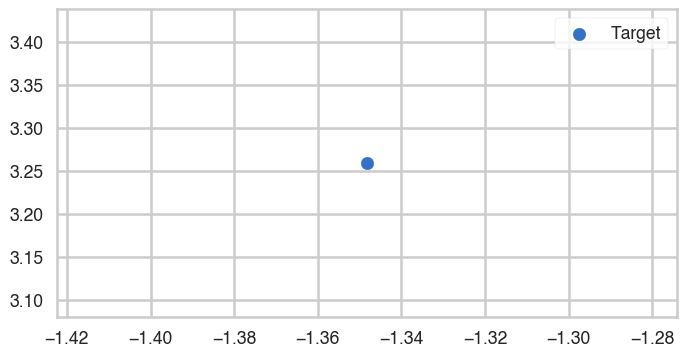

In [6]:
_ = plot_linear(x, yt=y_target)

# Train a single-feature linear model

In [36]:
num_epochs = 35
learning_rate = 0.00125

loss_fcn = match.nn.MSELoss()

# A single-neuron model
# model = match.nn.Linear(nx, ny)


# An alternative method for constructing the model
class Network(match.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = match.nn.Linear(nx, 2)
        self.linear2 = match.nn.Linear(2, ny)

    def forward(self, x):
        return self.linear2(self.linear1(x))

model = Network()


# Save model predictions for each epoch so that we can
# plot progress
predictions = []

for epoch in range(num_epochs):

    # Compute model output
    y_prediction = model(x)
    # Save prediction and a corresponding label
    loss = loss_fcn(y_prediction, y_target)
    predictions.append((y_prediction, epoch + 1, loss.data.item()))

    # Backpropagation
    model.zero_grad()
    loss.backward()

    # Update parameters
    for param in model.parameters():
        param.data = param.data - learning_rate * param.grad

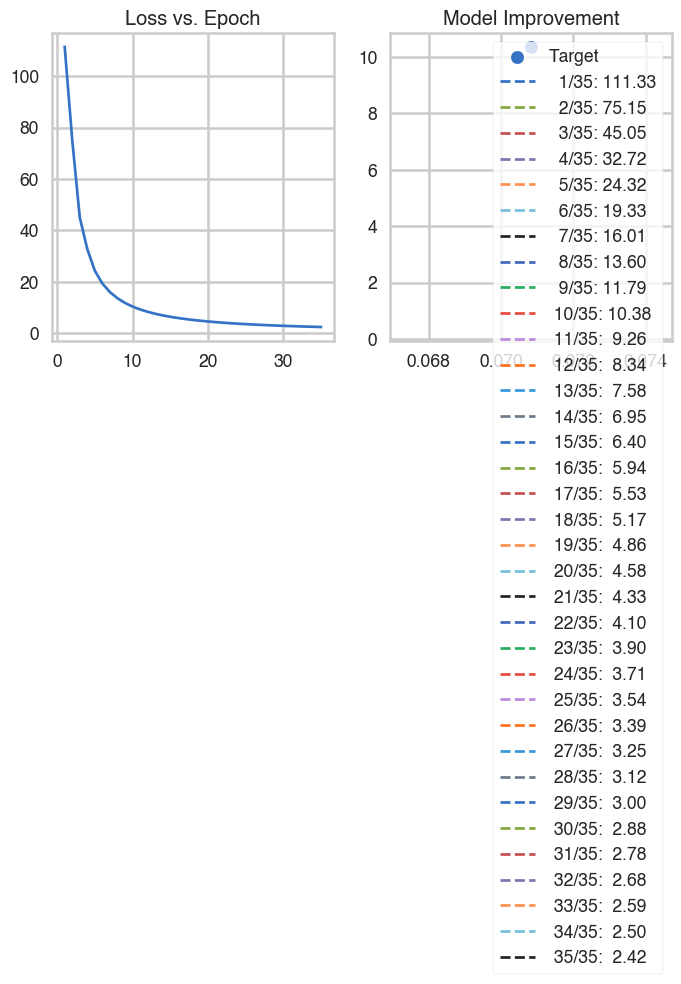

In [37]:
_, (ax_loss, ax_lines) = plt.subplots(1, 2, figsize=(8, 4))

losses = list(zip(*predictions))[2]
ax_loss.plot(range(1, num_epochs + 1), losses)
ax_loss.set_title("Loss vs. Epoch")

plot_linear(x, yt=y_target, ax=ax_lines)
for y_prediction, epoch, loss in predictions:
    label = f"{epoch:>3}/{num_epochs}: {loss:5.2f}"
    plot_linear(x, yp=y_prediction, ypl=label, ax=ax_lines)
_ = ax_lines.set_title("Model Improvement")

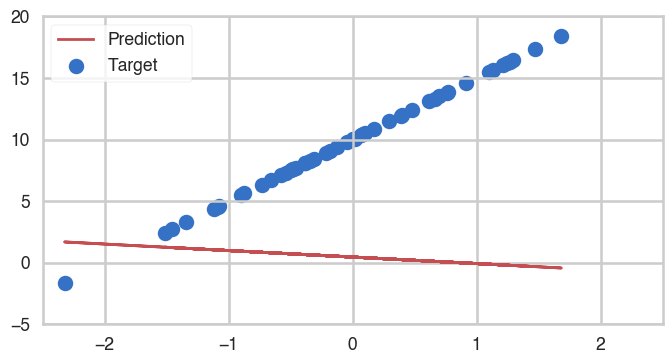

In [38]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.set_xlim([-2.5, 2.5])
ax.set_ylim([-5, 20])

line, = ax.plot([], [], color="r", lw=2, label="Prediction")

xT = x.T.data.vals
ytT = y_target.T.data.vals

ax.scatter(xT, ytT, lw=2, label="Target")

ax.legend()

def animate(frame):
    ypT = frame[0].T.data.vals
    line.set_data(xT, ypT)
    return line,

animation = FuncAnimation(fig, animate, predictions)

In [39]:
HTML(animation.to_jshtml())

In [ ]:
# animation.save("demo_linear_1d.mp4")

# Train a two-feature linear model¶

In [ ]:
num_points = 100
num_features = 2

x = match.randn(num_points, num_features)
true_weights = match.mat([[2.0, -1.0]])
y_target = x @ true_weights.T + 0.5

nx = x.shape[1]
ny = y_target.shape[1]

In [ ]:
plot_linear(x, yt=y_target)
_ = plt.title("Interactive Plot (Click and Drag Me)")

In [ ]:
num_epochs = 10
learning_rate = 0.1

loss_fcn = match.nn.MSELoss()

# A single-neuron model
model = match.nn.Linear(nx, ny)

# Save model predictions for each epoch so that we can
# plot progress
predictions = []

for epoch in range(num_epochs):

    # Compute model output
    y_prediction = model(x)
    # Save prediction and a corresponding label
    loss = loss_fcn(y_prediction, y_target)
    predictions.append((y_prediction, epoch + 1, loss.data.vals[0][0]))

    # Backpropagation
    model.zero_grad()
    loss.backward()

    # Update parameters
    for param in model.parameters():
        param.data = param.data - learning_rate * param.grad

In [ ]:
fig = plt.figure(figsize=(8, 4))

ax_loss = fig.add_subplot(121)

losses = list(zip(*predictions))[2]
ax_loss.plot(range(1, num_epochs + 1), losses)
ax_loss.set_title("Loss vs. Epoch")

# Plot just the first and final models
ax_lines = fig.add_subplot(122, projection="3d")
plot_linear(x, yt=y_target, ax=ax_lines)
ax_lines.set_title("Model Predictions (Click and Drag)")

# First model
yp, e, l = predictions[0]
plot_linear(x, yp=yp, ypl=f"{e:>3}/{num_epochs}: {l:5.2f}", ax=ax_lines)

# Final model
yp, e, l = predictions[-1]
_ = plot_linear(x, yp=yp, ypl=f"{e:>3}/{num_epochs}: {l:5.2f}", ax=ax_lines)